Note: This notebook assumes that "gmn_extract_candidate_contrails.ipynb" and "gmn_run_segmentation.ipynb" has been run.

This script visualises features from the SAM2 segmentation masks to see if contrails can be classified. In particular, we find that the length/width ratio of the segmentation masks works well for the classification.

In [1]:
import os
import glob
import json
from matplotlib import pyplot as plt
import numpy as np

In [2]:
indiv_stations  = ['US001N']
all_stations = False

dates = ['20230805']

# Just for this example on '20230805'
confirmed_flight_ids_with_contrails = ['3C6514_DLH413']

In [3]:
# Find all flights that have been extracted
flight_dirs = []

for date in dates:
    if all_stations:
        station_dirs = glob('../data/gmn_extracted_flight_images/*/')
        stations = []
        for station_dir in station_dirs:
            station_name = os.path.basename(os.path.normpath(station_dir))
            if os.path.isdir(os.path.join(station_dir, date)):
                stations.append(station_name)
            else:
                print(f'Could not find {station_name} for {date}, skipping')
    else:
        stations = indiv_stations

    for station in stations:
        curr_flight_dirs = [ f.path for f in os.scandir(f'../data/gmn_extracted_flight_images/{station}/{date}/') if f.is_dir() ]

        if len(curr_flight_dirs) > 0:
            if len(curr_flight_dirs) < 10:
                print(f'Warning: found fewer than 10 flights for {station} on {date}, it is likely that the camera calibration is faulty due to cloudy weather')
            flight_dirs += curr_flight_dirs
        else:
            print(f'Could not find find flights for {station} on {date}, skipping')

In [4]:
# Iterate through all flights and save the features extracted from the segmentation masks
ious = []
lengths = []
widths = []
total_areas = []
mask_in_bbox_percentage = []
temporal_variabilities = []

flight_ids = []
for flight_dir in flight_dirs:
    # Load json file in flight dir
    if os.path.exists(os.path.join(flight_dir, 'sam2_output', 'metadata.json')):
        with open(os.path.join(flight_dir, 'sam2_output', 'metadata.json')) as f:
            metadata = json.load(f)

    flight_id = os.path.basename(os.path.normpath(flight_dir))
    flight_ids.append(flight_id)
    ious.append(metadata['mask_features']['iou'])
    lengths.append(metadata['mask_features']['length'])
    widths.append(metadata['mask_features']['width'])
    total_areas.append(metadata['mask_features']['total_area'])
    mask_in_bbox_percentage.append(metadata['mask_features']['mask_in_bbox'])
    temporal_variabilities.append(metadata['mask_features']['temporal_variability'])

ious = np.array(ious)
lengths = np.array(lengths)
widths = np.array(widths)
length_width_ratio = lengths / widths
total_areas = np.array(total_areas)
mask_in_bbox_percentage = np.array(mask_in_bbox_percentage)
temporal_variabilities = np.array(temporal_variabilities)

C:\Users\Jacob\AppData\Local\Temp\ipykernel_17812\2680548399.py:28: RuntimeWarning: divide by zero encountered in divide
  length_width_ratio = lengths / widths


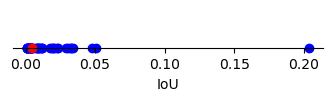

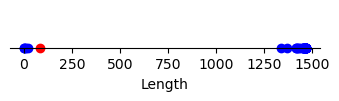

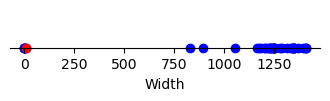

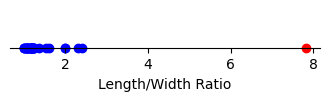

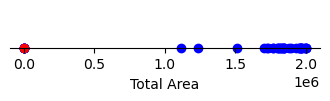

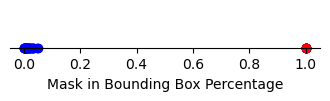

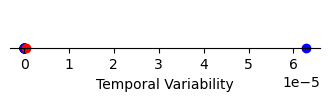

In [7]:
# Visualise the features as 1D scatter plots
def plot_1d_scatter(data, title, confirmed_contrail_indices, unconfirmed_contrail_indices):
    fig, ax = plt.subplots(1, 1, figsize=(4, 1))
    ax.scatter(data[unconfirmed_contrail_indices], [0] * len(unconfirmed_contrail_indices), c='b')
    ax.scatter(data[confirmed_contrail_indices], [0] * len(confirmed_contrail_indices), c='r')
    ax.get_yaxis().set_visible(False)
    ax.set_xlabel(title)
    ax.spines['left'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.spines['bottom'].set_position('zero')
    plt.show()
    
confirmed_contrail_indices = [i for i, flight_id in enumerate(flight_ids) if flight_id in confirmed_flight_ids_with_contrails]
unconfirmed_contrail_indices = [i for i, flight_id in enumerate(flight_ids) if flight_id not in confirmed_flight_ids_with_contrails]

plot_1d_scatter(ious, 'IoU', confirmed_contrail_indices, unconfirmed_contrail_indices)
plot_1d_scatter(lengths, 'Length', confirmed_contrail_indices, unconfirmed_contrail_indices)
plot_1d_scatter(widths, 'Width', confirmed_contrail_indices, unconfirmed_contrail_indices)
plot_1d_scatter(length_width_ratio, 'Length/Width Ratio', confirmed_contrail_indices, unconfirmed_contrail_indices)
plot_1d_scatter(total_areas, 'Total Area', confirmed_contrail_indices, unconfirmed_contrail_indices)
plot_1d_scatter(mask_in_bbox_percentage, 'Mask in Bounding Box Percentage', confirmed_contrail_indices, unconfirmed_contrail_indices)
plot_1d_scatter(temporal_variabilities, 'Temporal Variability', confirmed_contrail_indices, unconfirmed_contrail_indices)

We observe that a binary threshold for example: length/width ratio > 5, gives good classification in this case.

For more robustness, it might be worth using additional features. However, this does not seem to be necessary for the example we are looking at.

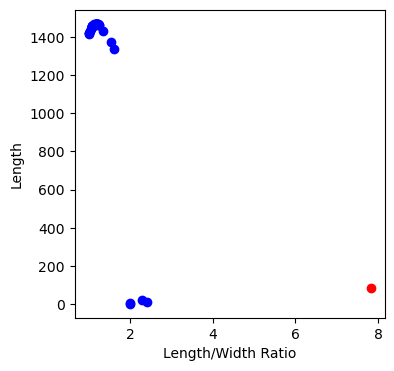

In [6]:
# Visualise in 2D how we could combine some features
def plot_2d_scatter(feat1, feat2, unconfirmed_contrail_indices, confirmed_contrail_indices):
    fig, axs = plt.subplots(1, 1, figsize=(4, 4))
    axs.scatter(feat1[0][unconfirmed_contrail_indices], feat2[0][unconfirmed_contrail_indices], c='b')
    axs.scatter(feat1[0][confirmed_contrail_indices], feat2[0][confirmed_contrail_indices], c='r')
    axs.set_xlabel(feat1[1])
    axs.set_ylabel(feat2[1])

plot_2d_scatter((length_width_ratio, 'Length/Width Ratio'), (lengths, 'Length'), unconfirmed_contrail_indices, confirmed_contrail_indices)